In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import random
from tabulate import tabulate

In [35]:
path = os.path.abspath('/content/drive/MyDrive/Colab Notebooks')
os.chdir(path)
print(path)

/content/drive/MyDrive/Colab Notebooks


### Loading the dataset
We load the train.csv dataset csv. Then perform the following:


*   Preprocess it to remove null records
*   Perform subsampling to get actual training dataset
*   Create python script to restructure images in the correct folder structure for performing classification.
*   Lastly, upload image dataset to google drive and perform classification



In [36]:
train_df = pd.read_csv("train.csv")
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


### Preprocessing of the datasets


In [37]:
print("The number of rows and columne in train.csv: {}".format(train_df.shape))
print(train_df.columns)
print("\nDATA TYPES\n")
print(train_df.dtypes)
print("\n=================================================\n")
print("\nCOLUMN COUNT\n")
print(train_df.count())
print("\nNULL COUNT\n")
print(train_df.isnull().sum())
train_df.dropna(axis=0, inplace=True)

The number of rows and columne in train.csv: (33126, 8)
Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target'],
      dtype='object')

DATA TYPES

image_name                        object
patient_id                        object
sex                               object
age_approx                       float64
anatom_site_general_challenge     object
diagnosis                         object
benign_malignant                  object
target                             int64
dtype: object



COLUMN COUNT

image_name                       33126
patient_id                       33126
sex                              33061
age_approx                       33058
anatom_site_general_challenge    32599
diagnosis                        33126
benign_malignant                 33126
target                           33126
dtype: int64

NULL COUNT

image_name                         0
patient_id                  

In [38]:
# Passed a dictionary to astype() function
train_df2 = train_df.astype({'patient_id':'category',"sex":'category', "diagnosis":'category',
                             'benign_malignant':'category','target':'category',
                             'anatom_site_general_challenge':'category'})

After preprocessing

In [39]:
print("The number of rows and columne in train.csv: {}".format(train_df2.shape))

The number of rows and columne in train.csv: (32531, 8)


### Subsampling
Based on the dataset, we start by selecting a single image per patient that is selecting images by patient Id and exporting the record to a new train.csv file.

This will then be loaded by a python script to build a `dir` of image set from the original image set for training and classification.

Subsampling is done by checking getting the patient images that are malignant or benign. If the patient id has malignant samples, we sample 1. Else if the patient id has benign sample, we sample 1. This is done to make the dataset have enough representation of malignant as well as benign data while representing every patient.

In [40]:
# Set a seed value
seed_value= 12321 
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

In [83]:
# Get patient id as category
# Prepare two datasets:
# for each patient_id
    # select get records
      # if malignant
        # sample 1
      # elseif benign
        # sample 1

unique_patient_id = train_df2.patient_id.cat.categories
malignant_df = train_df2[train_df2['target'] == 1]

benign_df = train_df2[train_df2['target'] == 0]
sample_indices = []
#samples per patient
for  patient_id in unique_patient_id:
  patient_sample = malignant_df[malignant_df['patient_id']==patient_id]
  if patient_sample.size:
     sample_indices.append(patient_sample.sample(n=1, random_state=seed_value).index[0])
  else:
     patient_sample = benign_df[benign_df['patient_id']==patient_id]
     if patient_sample.size: 
       sample_indices.append(patient_sample.sample(n=1, random_state=seed_value).index[0])

sample_df = train_df2.loc[sample_indices]
print("Sample length",len(sample_indices))
sample_df.tail()

Sample length 2051


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
20580,ISIC_6260841,IP_9989332,female,30.0,lower extremity,unknown,benign,0
1346,ISIC_0508284,IP_9992027,female,50.0,lower extremity,unknown,benign,0
15209,ISIC_4655392,IP_9995095,male,55.0,torso,nevus,benign,0
20995,ISIC_6378963,IP_9996429,male,55.0,upper extremity,unknown,benign,0
1742,ISIC_0624498,IP_9997715,female,80.0,torso,melanoma,malignant,1


### Visualizing the dataset

In [86]:
sample_df.groupby('benign_malignant').count()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,target
benign_malignant,,,,,,,
benign,1628,1628,1628,1628,1628,1628,1628
malignant,423,423,423,423,423,423,423


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


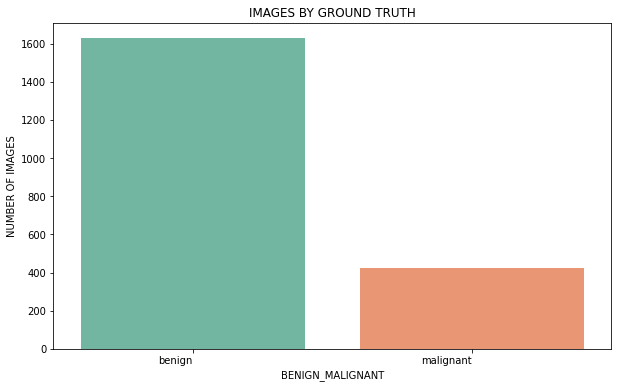

In [84]:
plt.figure(figsize=(10, 6))
chart = sns.countplot(sample_df.benign_malignant,
    x="benign_malignant",
    palette='Set2'
)
chart.set_xticklabels(chart.get_xticklabels(), 
                      rotation=0, horizontalalignment='right')
plt.title("IMAGES BY GROUND TRUTH")
plt.xlabel("BENIGN_MALIGNANT")
plt.ylabel("NUMBER OF IMAGES")
plt.show()

### Export to csv

In [87]:
sample_df.to_csv('sample1.csv',index=False)